Notebook Logistic Regression Case
Oefening Data Scientist 
Geert Vandezande

Doel:
- Supervised Learning toepassen
- EDA uitvoeren op een dataset
- Logistic Regression toepassen op de data voor classificatie

Dataset: 
- More info: see kaggle https://www.kaggle.com/datasets/arifmia/heart-attack-risk-dataset


Volgorde van activiteiten in deze notebook: (cfr Datacamp "preparing data for modelling)
- data inlezen
- data bekijken, visueel en numerisch
- missing data oplossen 
- incorrect types controleren
- Numerische waarde standardizeren
- Categorische varaiabelen processen
- Feature engineering
- select features for modelling
- unbalance van de features corrigeren met SMOTE
- modeling met Logistic Regression, Decision Tree Regression en Random Forrest Regression
- modeling met Hyperparameter tuning met GridSearchCV
- modeling met Optuna voor Hyperparameter tuning

In [ ]:
# import van de diverse modules
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.datasets import make_classification
from sklearn.ensemble import IsolationForest
from collections import Counter

# Machine learning algorithm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB

# Evaluation
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, r2_score

# system utils
import warnings
from pathlib import Path
import datetime
from colorama import Fore, Back, Style
import sys
import os
import chardet
from summarytools import dfSummary
from tabulate import tabulate


plot_graphs = True

Extra code snippits die doorheen de notebook gebruikt worden:

save_fig: na generatie van een image kan de image naar file geschreven worden in de images/.. directory. Geef steeds een zinvolle naam

read_JSON: om eenvoudig een JSON in te lezen

log_info:
- logging functie om doorheen de notebooks de status naar file te kunnen schrijven. 
- de logstatements worden tijdens de uitvoering van de code bewaard in een list. Die kan tussentijds naar het scherm geprint worden of naar een file
- log_info_write_to_file: schrijf de loginformatie naar file 
- log_info_print_on_screen: print alle loginfo naar het scherm

In [46]:
# enkele extra code snippets gebruikt doorheen de oefening

# to plot or not to plot - zet op True om de plots te zien, zet op False om de plots niet te zien bij een Run ALL
plot_graphs = True


# schrijf een visual naar file

IMAGES_PATH = Path() / "images" 
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Lezen van de JSON-file

def read_JSON(file_path_read):
    with open(file_path_read, 'r') as file:
        files_from_json = json.load(file)
    return files_from_json


# functies om te loggen naar file

log_info_lijst = []

log_filenaam = "LogReg_continue"
if os.path.exists(log_filenaam):
    os.remove(log_filenaam)


def log(log_code="INFO", boodschap="euh geen boodschap????"):
    global log_info_lijst
    now = datetime.datetime.now()
    formatted_date = now.strftime("%d/%m/%Y %H:%M:%S")
    log_message = f"{Style.RESET_ALL}{formatted_date} : {log_code} : {boodschap}"
    log_info_lijst.append(log_message)
    with open(log_filenaam, 'a') as file:  # Open the file in append mode
        file.write(boodschap + '\n')  # Voeg een nieuwe regel toe na elke string
    print(log_message)
    return

def log_info(boodschap):
    log("Info",boodschap)
    def log_info_write_to_file(filename):
        with open(filename, 'a') as file:  # Open the file in append mode
            for string in log_info_lijst:
                file.write(string + '\n')  # Voeg een nieuwe regel toe na elke string
        return

def log_info_write_to_file(filename):
    with open(filename, 'w') as file:
        for string in log_info_lijst:
            file.write(string + '\n')  # Voeg een nieuwe regel toe na elke string
    return




def log_info_print_on_screen():
    for boodschap in log_info_lijst:
        print(boodschap)    
    return

In [47]:
def plot_histogram_old(df_hist, column, bins = 50, figuur_naam = 'Overzicht kolommen'):
    plt.rc('font', size=14)
    plt.rc('axes', labelsize=14, titlesize=14)
    plt.rc('legend', fontsize=14)
    plt.rc('xtick', labelsize=10)
    plt.rc('ytick', labelsize=10)
    # plt.hist(df_hist[column], color='blue', alpha=0.7)
    plt.title('Histogram van Heart Rate')
    plt.xlabel('Heart Rate')
    plt.ylabel('Frequentie')
    if plot_graphs:
        df_hist[column].hist(bins, figsize=(12, 8))
        save_fig(figuur_naam)  # extra code
    plt.show()



def plot_histogram(dataframe, column, bins=20, color='blue', title='', xlabel='', ylabel='Frequentie', filenaam = "Histogram"):
    """
    Deze functie plot een histogram van een gespecificeerde kolom uit een pandas DataFrame.
    
    Parameters:
        dataframe (pd.DataFrame): Het DataFrame dat de data bevat.
        column (str): De naam van de kolom waarvan een histogram moet worden geplot.
        bins (int): Het aantal bins (groepen) voor het histogram.
        color (str): De kleur van de histogram bars.
        title (str): De titel van de plot.
        xlabel (str): De label voor de x-as.
        ylabel (str): De label voor de y-as.
    """
    # Controleer of de kolom bestaat in het DataFrame
    if column not in dataframe.columns:
        print(f"Kolom '{column}' niet gevonden in het DataFrame.")
        return

    # Plot het histogram
    plt.hist(dataframe[column], bins=bins, color=color, alpha=0.7)
    plt.title(title if title else f'Histogram van {column}')
    plt.xlabel(xlabel if xlabel else column)
    plt.ylabel(ylabel)
    if plot_graphs:
        save_fig(filenaam)
        plt.show()

Hulpfuncties

bereken_percentage_outliers: via Isolation forest wordt het percentage van de outliers berekend.
- df : dataframe
- columns_to_use: list van koloms die gebruikt worden om de outliers te berekenen
- functie geeft een percentage terug van het aaantal outliers op het totaal aantal observaties


cap_values: vervang outliers door hun lower of upperpercentieel waarde: de whiskers worden berekend door van de lower_percentieel waarde een waarde af te trekken gelijk aan 1,5 * IQR (interquartile range), voor upper_percentieel waarde wordt de 1,5 * IQR bijgeteld
- df: dataframe
- columns_to_use
- lower_percentieel (default = 25)
- upper_percentieel (default = 75)


BinaryValueEncoder: hulp klasse om categorische te classificeren naar 0 en 1
- string_zero: indien categorische waarde = string_zero, krijgt de nieuwe waarde 0
- string_one: indien categorische waarde = string_zero, krijgt de nieuwe waarde 1
Try-out om zelf eens een class te schrijven voor transformation. Kan uiteraard ook via OneHotEncoding gedaan worden


In [48]:
# functie om het percentage outliers te berkenen voor een set van kolommen in een dataframe
def bereken_percentage_aantal_outliers(df , columns_to_use):
    # Initialiseren van het Isolation Forest model
    iso_forest = IsolationForest(n_estimators=100, contamination='auto', random_state=42)

    # Fit het model
    iso_forest.fit(df[columns_to_use])
    # Voorspellingen
    # Het geeft -1 voor outliers en 1 voor inliers
    labels = iso_forest.predict(df[columns_to_use])
    # Toevoegen van de labels aan het DataFrame om outliers te identificeren
    df_intern = df.copy()
    df_intern['outlier'] = labels
    outliers = df_intern[df_intern['outlier'] == -1]
    aantal_outliers = df_intern['outlier'].value_counts()
    print(aantal_outliers)
    percentage_aantal_outliers = (len(outliers) / len(df_intern)) * 100

    return percentage_aantal_outliers


# functie om outliers in een kolom te cappen op een percentiel waarde
def cap_values(df_input, column, lower_percentile=25, upper_percentile=75):
    # voeg code toe om beter de outliers te verwijderen
    log("Info", f"Capping values voor kolom {column} naar lower percentiel {lower_percentile} - upper percentiel {upper_percentile}")
    q1, q3 = np.percentile(df_input[column], [lower_percentile, upper_percentile])  # Calculate the 25th (Q1) and 75th (Q3) percentiles
    iqr = q3 - q1  # Calculate the interquartile range (IQR)
    lower_bound = q1 - 1.5 * iqr  # Calculate lower whisker (Q1 - 1.5 * IQR)
    upper_bound = q3 + 1.5 * iqr  # Calculate upper whisker (Q3 + 1.5 * IQR)

    # lower_bound = df[column].quantile(lower_percentile)
    # upper_bound = df[column].quantile(upper_percentile)
    
    # Waarden cappen met behulp van de numpy.where functie
    df_output = df_input.copy()
    df_output[column] = np.where(df_input[column] < lower_bound, lower_bound, df_input[column])
    df_output[column] = np.where(df_input[column] > upper_bound, upper_bound, df_input[column])    
    return df_output


In [49]:
# data inlezen van de file


heart_attack_risk_dataset_filename = 'data/heart_attack_risk_dataset.csv'
df = pd.read_csv(heart_attack_risk_dataset_filename)
log_info(f"File ingelezen: {heart_attack_risk_dataset_filename}")
df_raw = df.copy() # hou het ruwe dataframe bij


# lijst met features opgedeeld in numerisch en categorisch
df_col = df.columns
print(df_col)

# bepaal eerst de opdeling van numerische en categorische waarden op basis van de kolommen
# 3 opties

# optie 1: op basis van het datatype in de kolome
# df_num_col = df.select_dtypes(include='number').columns
# df_cat_col = df.select_dtypes(include='object').columns


# optie 2: op basis van de voorkomens van de waarden, indien <=4 is het een categorische 
# minder goed
df_cat_col = [i for i in df.columns if df[i].nunique() <= 4]
df_num_col= [i for i in df.columns if i not in df_cat_col]

# optie 3: en dit is de manuele manier om de lijst van kolommen voor numerische en categorische waarden samen te stellen
# check in via info() en describe() 
# we gaan dit verder gebruiken
df_num_col = ['Age', 'BMI', 'Cholesterol_Level', 'Resting_BP', 'Heart_Rate', 'Max_Heart_Rate_Achieved']
df_cat_col = list(set(df_col) - set(df_num_col))
df_label_col = ['Heart_Attack_Risk'] # dit is de te voorspellen waarde
df_cat_nom_col = ['Gender', 'Physical_Activity_Level', 'Stress_Level', 'Chest_Pain_Type', 'Thalassemia', 'ECG_Results', 'Heart_Attack_Risk']
df_cat_ord_col = list(set(df_cat_col) - set(df_cat_nom_col))

df_num = df[df_num_col]
df_cat = df[df_cat_col]
df_label = df[df_label_col]
df_cat_nom = df[df_cat_nom_col]
df_cat_ord = df[df_cat_ord_col]



12/02/2025 10:25:03 : Info : File ingelezen: data/heart_attack_risk_dataset.csv
Index(['Age', 'Gender', 'Smoking', 'Alcohol_Consumption',
       'Physical_Activity_Level', 'BMI', 'Diabetes', 'Hypertension',
       'Cholesterol_Level', 'Resting_BP', 'Heart_Rate', 'Family_History',
       'Stress_Level', 'Chest_Pain_Type', 'Thalassemia', 'Fasting_Blood_Sugar',
       'ECG_Results', 'Exercise_Induced_Angina', 'Max_Heart_Rate_Achieved',
       'Heart_Attack_Risk'],
      dtype='object')


In [50]:
# eerste controles van alle waarden: 
# zijn er nulwaarden?
# zitten er geen duplicates tussen?

df.head()

# Maak een samenvatting 
df_summary = df.describe().transpose()
# Zet DataFrame om naar een mooie teksttabel
summary_str = tabulate(df_summary, headers='keys', tablefmt='psql')
# Print de string
log_info(f"\nDescribe van de dataset")
log_info(summary_str)

# check op nulwaarden:
aantal_nul_waarden = df.isnull().sum()
log_info(f"\nCheck op nulwaarden: \n{aantal_nul_waarden}")
# ok, geen nulwaarden

aantal_duplicated_waarden = df.duplicated().sum()
log_info(f"\nCheck op duplicates: \n{aantal_duplicated_waarden}")
# ok, geen duplicates







12/02/2025 10:25:03 : Info : 
Describe van de dataset
12/02/2025 10:25:03 : Info : +-------------------------+---------+-----------+-----------+-------+--------+--------+--------+-------+
|                         |   count |      mean |       std |   min |    25% |    50% |    75% |   max |
|-------------------------+---------+-----------+-----------+-------+--------+--------+--------+-------|
| Age                     |   50000 |  53.3987  | 20.799    |    18 |  35    |  53    |  71    |    89 |
| Smoking                 |   50000 |   0.29842 |  0.457569 |     0 |   0    |   0    |   1    |     1 |
| Alcohol_Consumption     |   50000 |   0.40198 |  0.490303 |     0 |   0    |   0    |   1    |     1 |
| BMI                     |   50000 |  27.5194  |  7.22518  |    15 |  21.27 |  27.54 |  33.77 |    40 |
| Diabetes                |   50000 |   0.19884 |  0.399131 |     0 |   0    |   0    |   0    |     1 |
| Hypertension            |   50000 |   0.29738 |  0.45711  |     0 |   0    

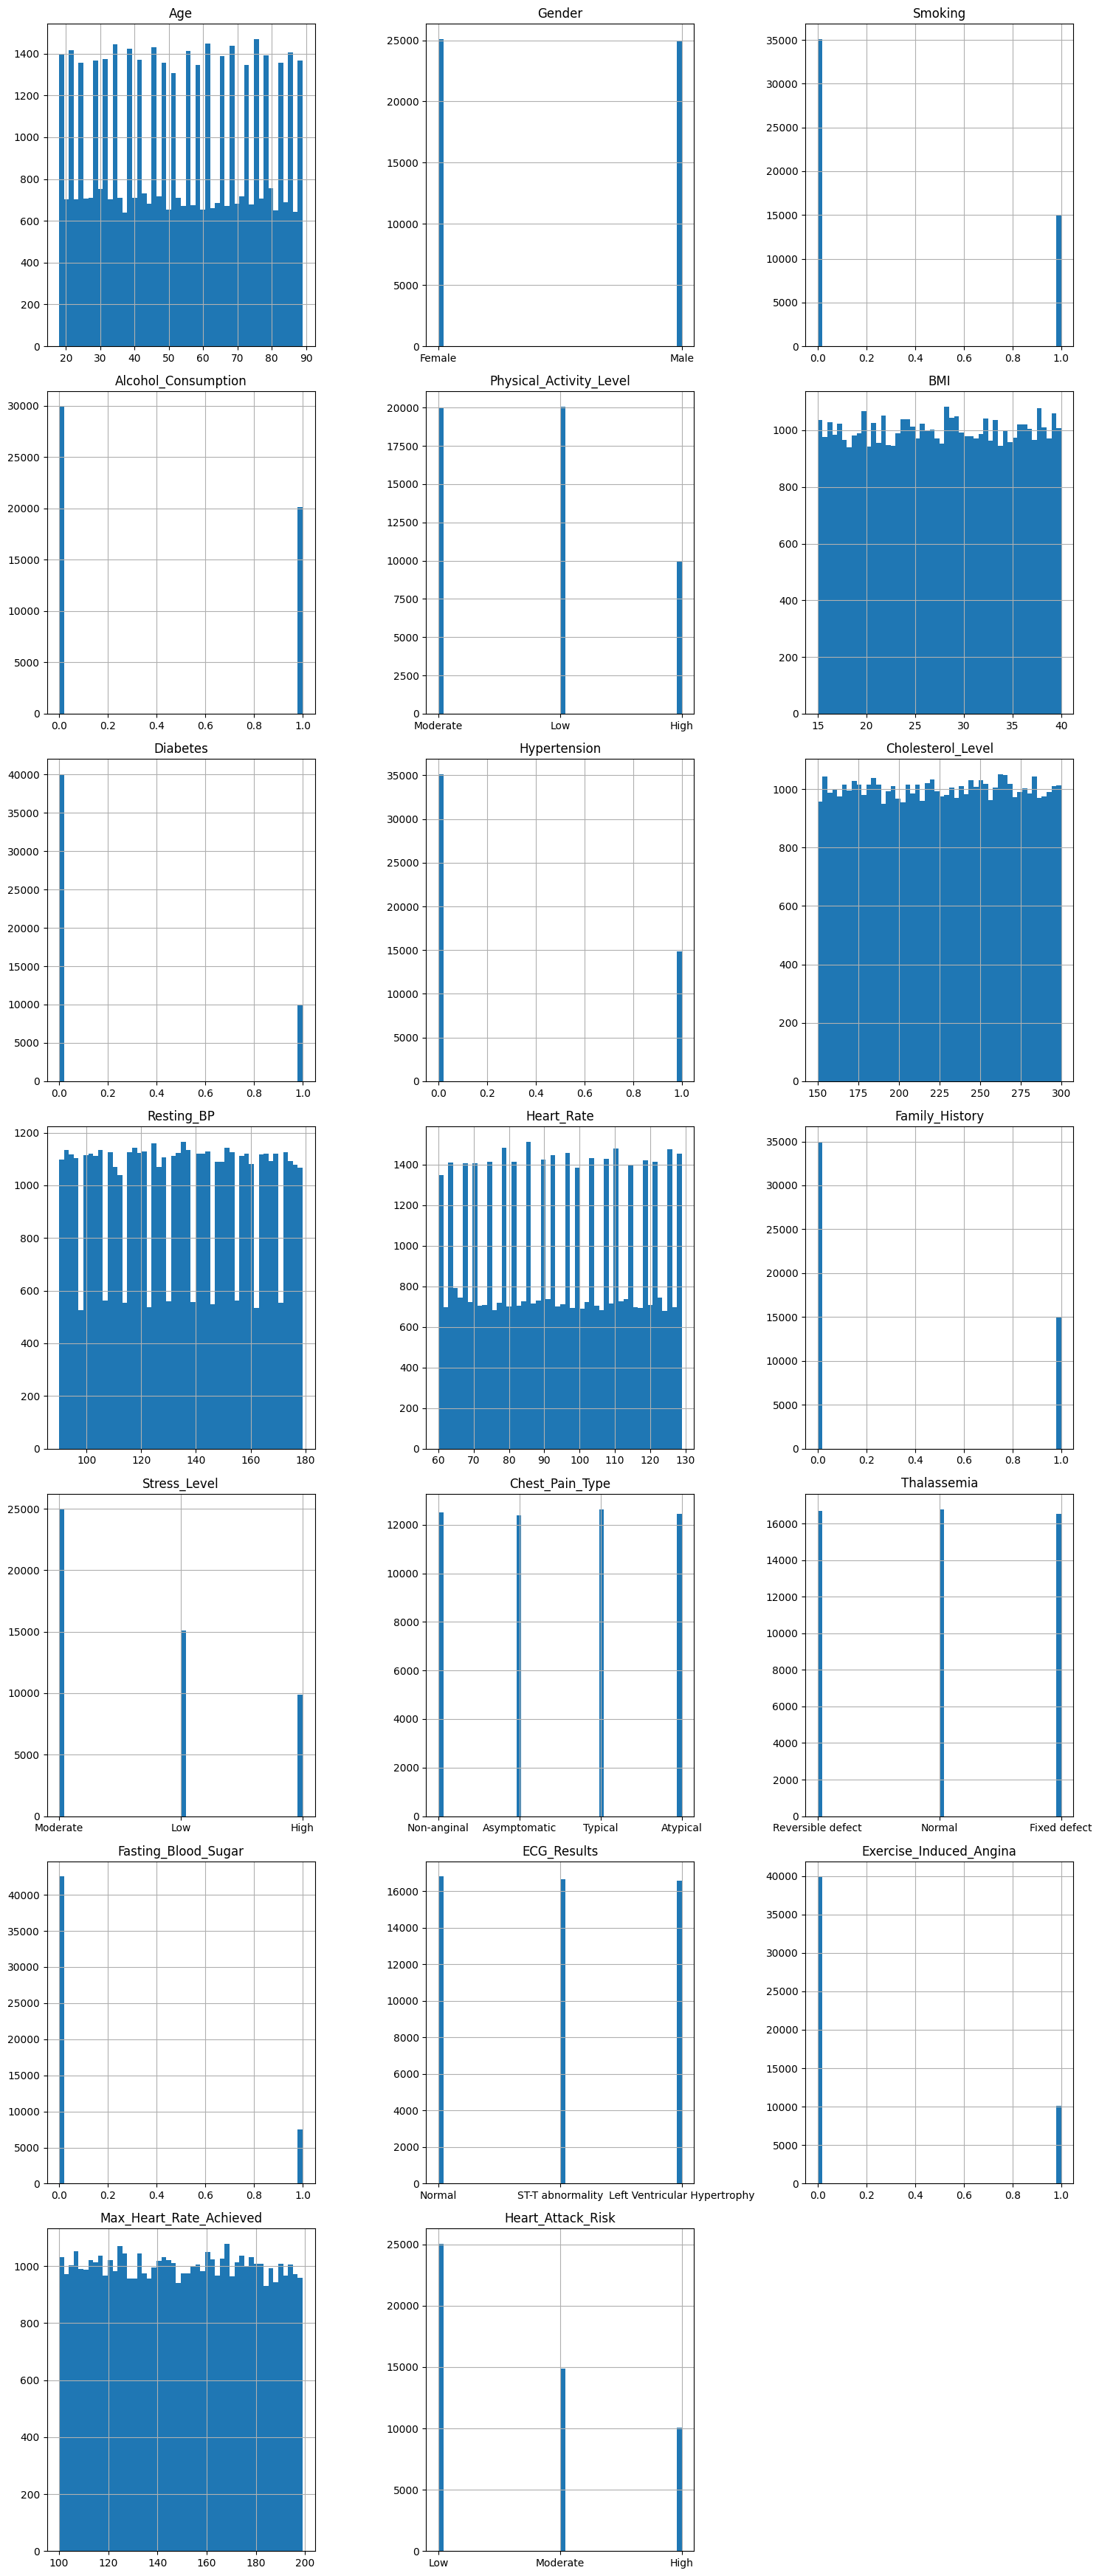

In [51]:
# We nemen eerst een snelle blik op de variabelen via een histogram plot van alle features
# We maken een algemene plot van de variabelen

if plot_graphs:
    num_columns = 3
    num_plots = len(df.columns)
    num_rows = (num_plots + num_columns - 1) // num_columns
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, num_rows * 5))
    axes = axes.flatten()
    for i, column in enumerate(df.columns):
        df[column].hist(bins=50, ax=axes[i])
        axes[i].set_title(column)
    # Hide any unused subplots
    for i in range(num_plots, len(axes)):
        fig.delaxes(axes[i])
    plt.tight_layout()
    save_fig("algemeen_overzicht_features")
    plt.show()

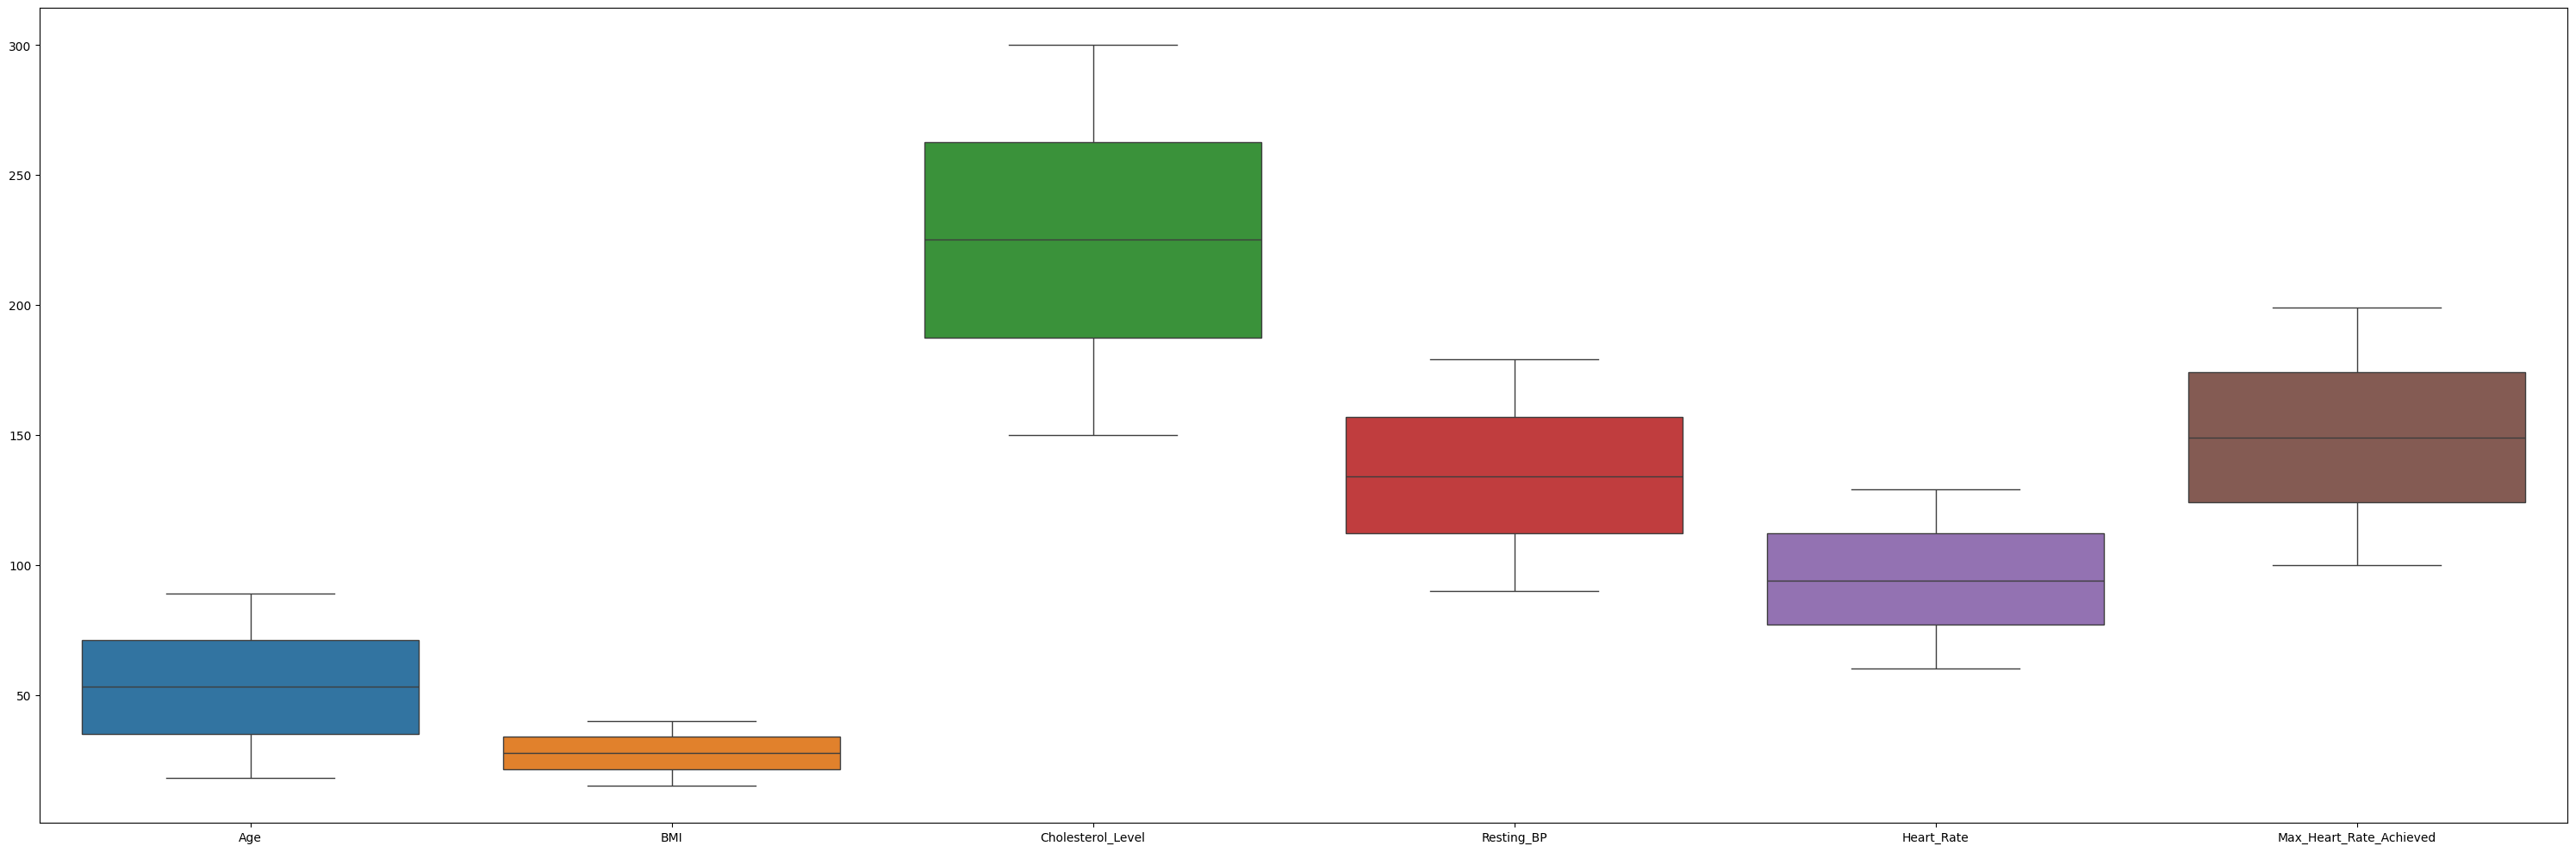

C:\Users\geert\AppData\Local\Temp\ipykernel_3572\865232696.py:24: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(df[col], kde=True, palette='skyblue')
C:\Users\geert\AppData\Local\Temp\ipykernel_3572\865232696.py:24: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(df[col], kde=True, palette='skyblue')
C:\Users\geert\AppData\Local\Temp\ipykernel_3572\865232696.py:24: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(df[col], kde=True, palette='skyblue')
C:\Users\geert\AppData\Local\Temp\ipykernel_3572\865232696.py:24: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(df[col], kde=True, palette='skyblue')
C:\Users\geert\AppData\Local\Temp\ipykernel_3572\865232696.py:24: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(df[col], kde=True, palette='skyblue')
C:\Users\geert\AppDa

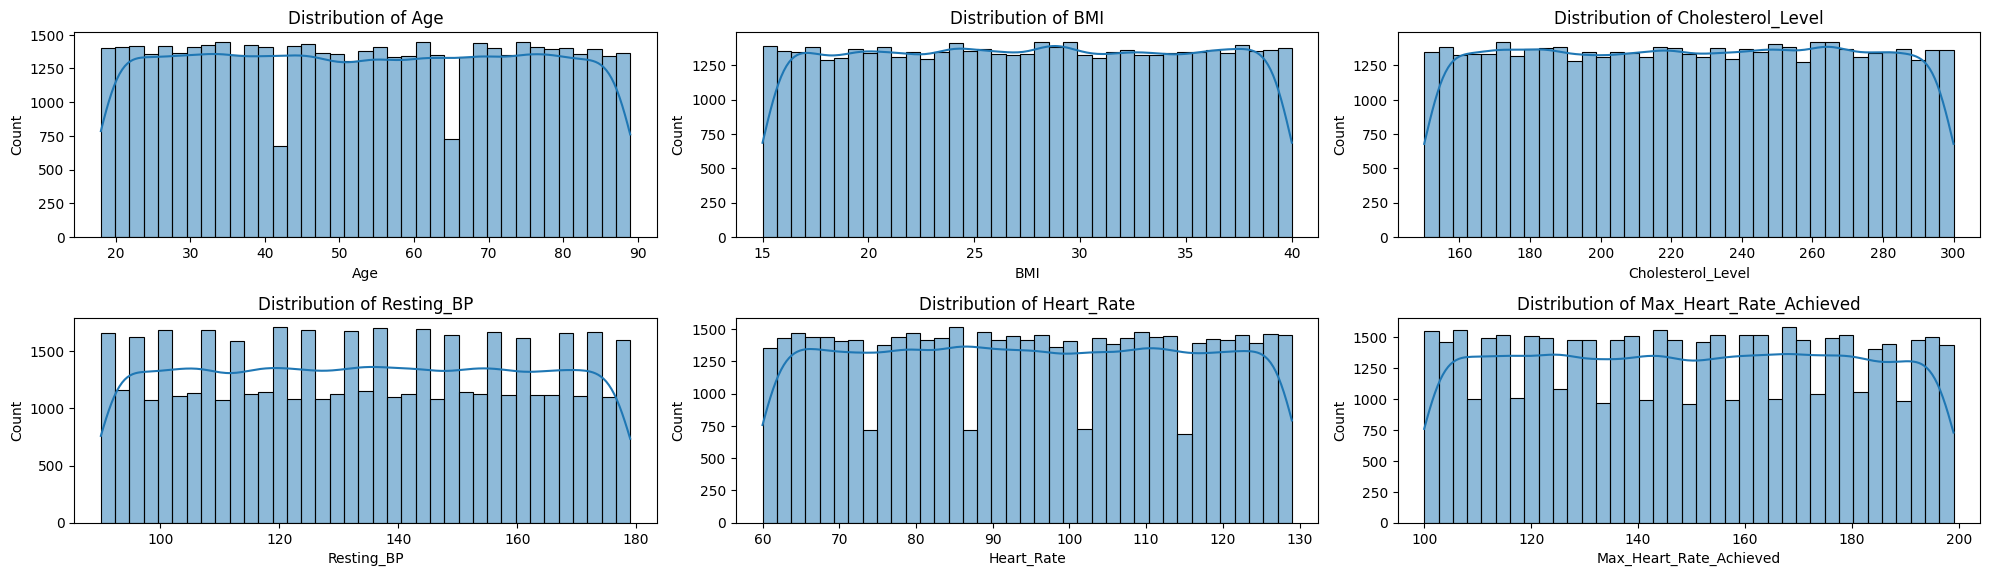

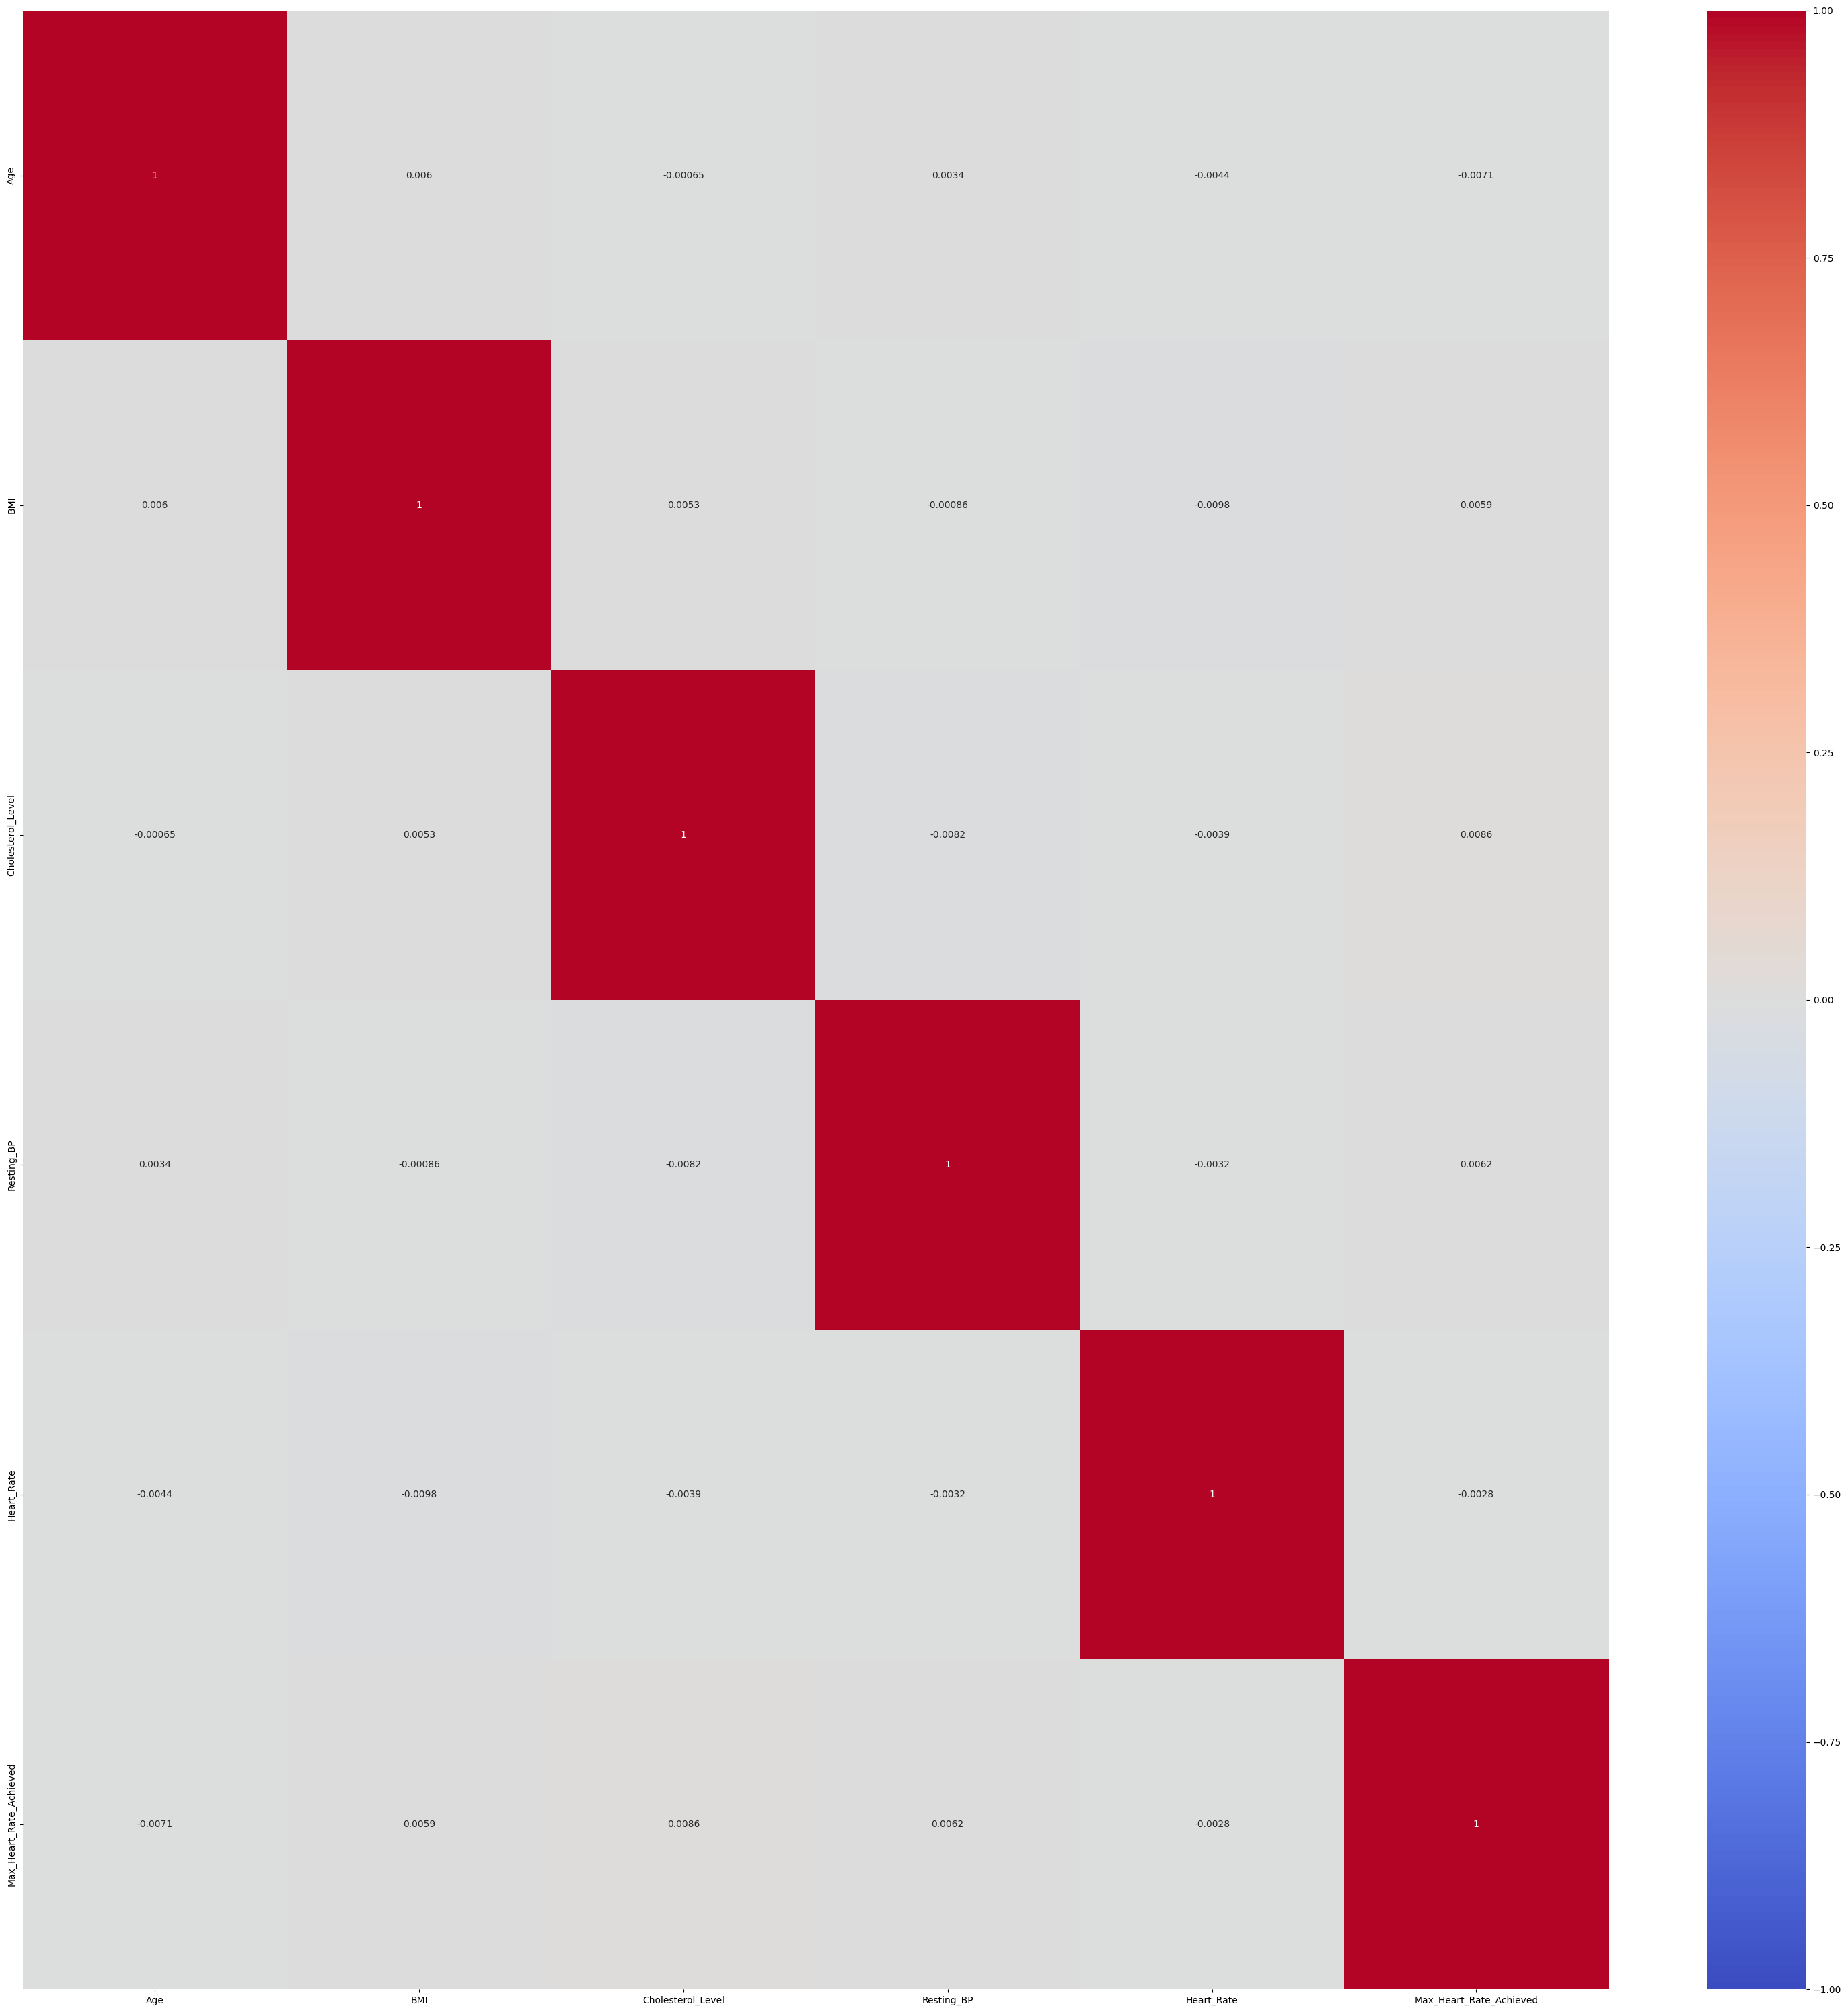

In [52]:
# analyze van de features, eerst de numerische features
# eerst een boxplot, voor de numerische waarde


# outliers berekenen maar hier doen we voorlopig niets mee
# aantal_outliers = bereken_percentage_aantal_outliers(df,['Age'])
# print(aantal_outliers)


# eerste een box-plot van de numerische variabelen
if plot_graphs:
    fig = plt.figure(figsize=(30,10))
    sns.boxplot(df_num)
    save_fig("Numerische features boxplot van de features")
    plt.show()
# Dit lijkt een normale verdeling. Er is hier geen log-verfijning nodig
# Er zijn ook geen outliers


# We maken nog een apart histogram van de numersiche variabelen
plt.figure(figsize=(20,14))
for i, col in enumerate(df_num_col,1):
    plt.subplot(5,3,i)
    sns.histplot(df[col], kde=True, palette='skyblue')
    plt.title(f"Distribution of {col}")
if plot_graphs:
    plt.tight_layout()
    save_fig("Numerische features histogram van de features")
    plt.show()
# Alles lijkt ook hier normaal


# Is er een correlatie tussen de numerische variabelen?
# Create corraltion heatmap
if plot_graphs:
    fig = plt.figure(figsize=(30,30))
    sns.heatmap(df_num.corr(), vmin=-1, vmax=1, annot=True, cmap='coolwarm')
    save_fig("Numerische features: heatmap van de correlatie")
    plt.show()


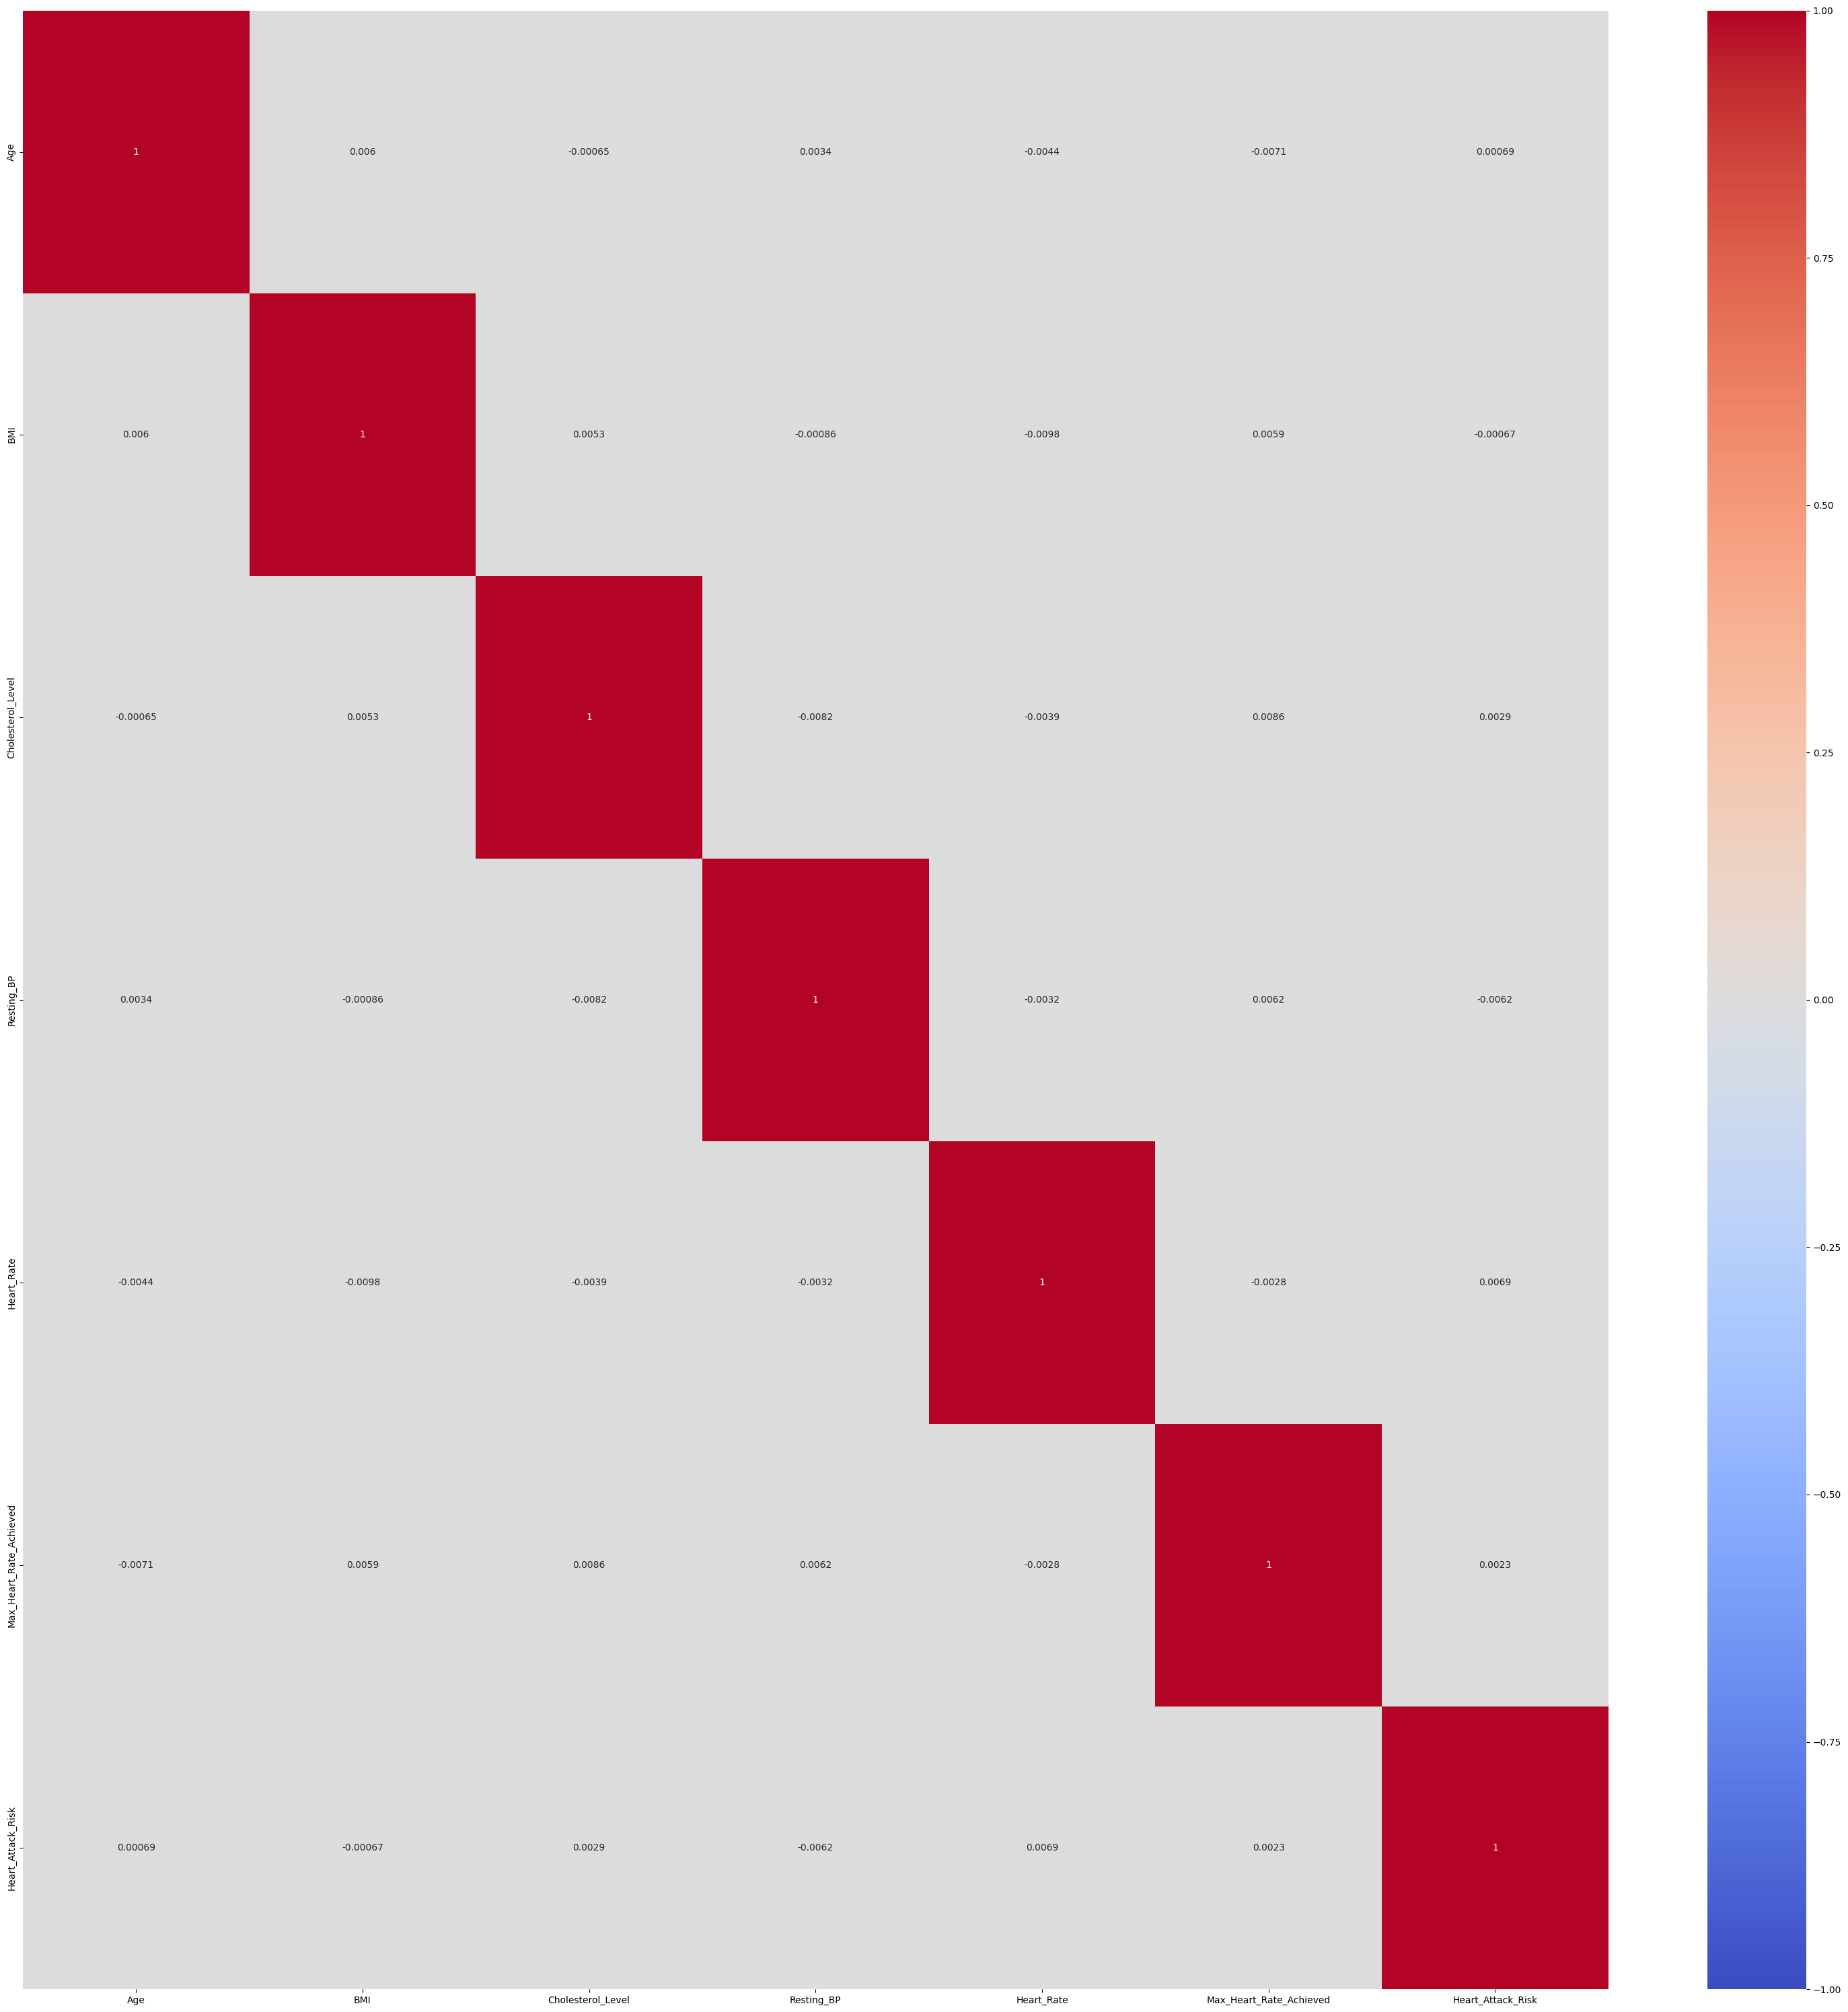

In [53]:
# is er een correlatie tussen de numerische variabelen en de target value?
# hiervoor gaan we even de target valeu mappen naar een numerische waarde
df_corr = pd.concat([df_num, df[df_label_col]], axis=1)
df_corr.Heart_Attack_Risk = df_corr.Heart_Attack_Risk.map({'Low':1,'Moderate':2,'High':3})
df_corr.head()

if plot_graphs:
    fig = plt.figure(figsize=(30,30))
    sns.heatmap(df_corr.corr(), vmin=-1, vmax=1, annot=True, cmap='coolwarm')
    save_fig("Numerische features: heatmap van de correlatie")
    plt.show()


# mmm, precies toch niet zo heel veel...


In [54]:
# analyze van de categorische features

print(df_cat.head())
print(df_cat.describe())

   Diabetes  Family_History  Gender  Smoking  Alcohol_Consumption  \
0         1               0  Female        1                    0   
1         0               0    Male        0                    0   
2         0               0    Male        0                    1   
3         1               0    Male        0                    1   
4         0               0  Female        1                    0   

  Stress_Level  Hypertension        Thalassemia                   ECG_Results  \
0     Moderate             0  Reversible defect                        Normal   
1          Low             0             Normal              ST-T abnormality   
2          Low             0  Reversible defect              ST-T abnormality   
3          Low             0       Fixed defect  Left Ventricular Hypertrophy   
4         High             0  Reversible defect              ST-T abnormality   

  Heart_Attack_Risk Chest_Pain_Type  Exercise_Induced_Angina  \
0               Low     Non-angina

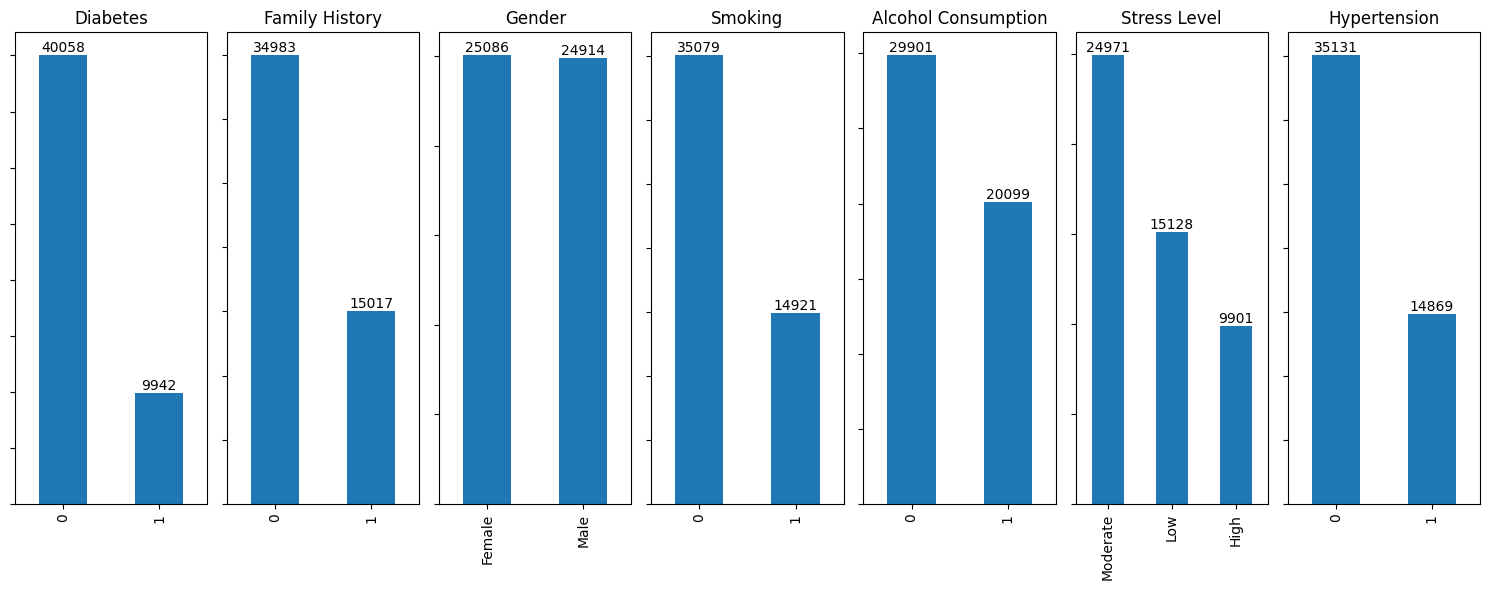

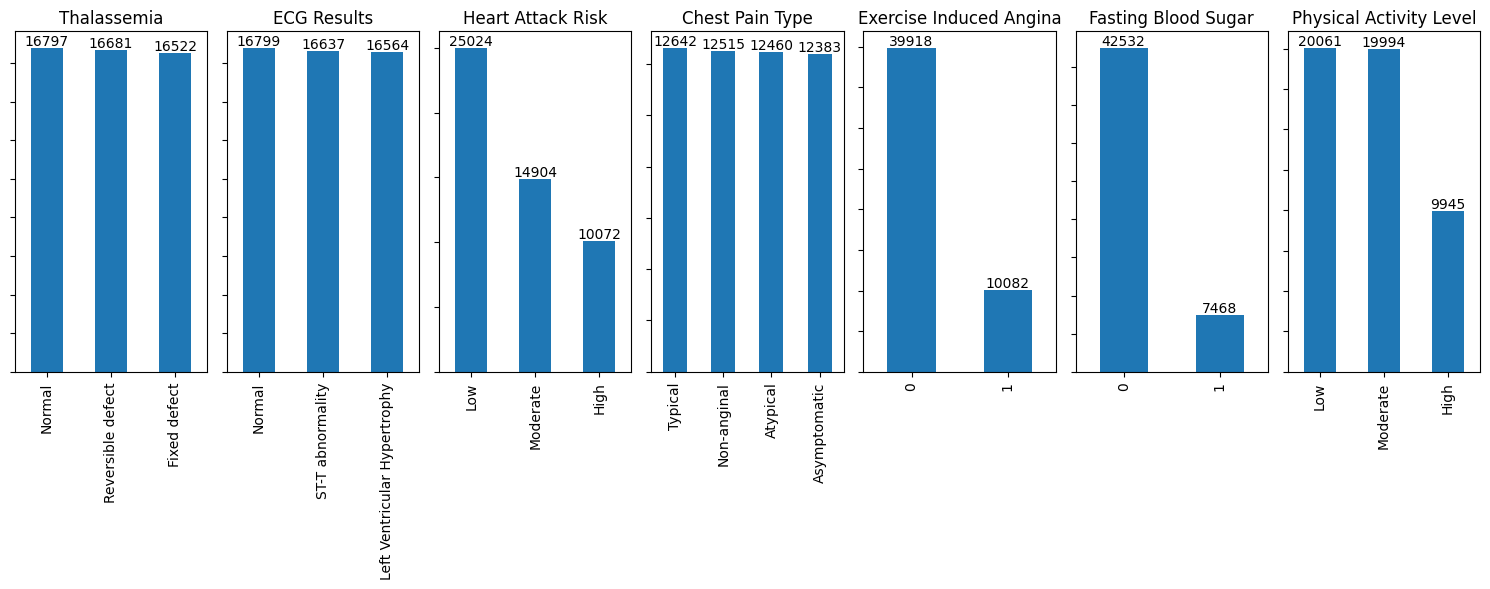

In [55]:
# maak per categorsiche variabel een bar_plot van de voorkomens van de waarden

def bar_labels(axes, rotation= 0, location="edge"):
    for container in axes.containers:
        axes.bar_label(container, rotation=rotation, label_type=location)
    axes.set_ylabel("")
    axes.set_xlabel("")
    axes.set_yticklabels(())

# plot de categorische waarde af met het voorkomen van de waarde in de dataset
# 14 plots, opgedeeld in 2 rijen met 7 plots

if plot_graphs:
    index = 0
    for r in range(2):
        fig, axes = plt.subplots(ncols=7, figsize=(15, 6))
        for i in range(7):
            df[df_cat_col[index]].value_counts().plot(kind="bar", ax=axes[i])
            bar_labels(axes[i])
            axes[i].set_title(df_cat_col[index].replace('_', ' '))
            
            index+=1      
        plt.tight_layout()   
        save_fig(f"Categorische features value count van de feature deel{r}")
        plt.show()


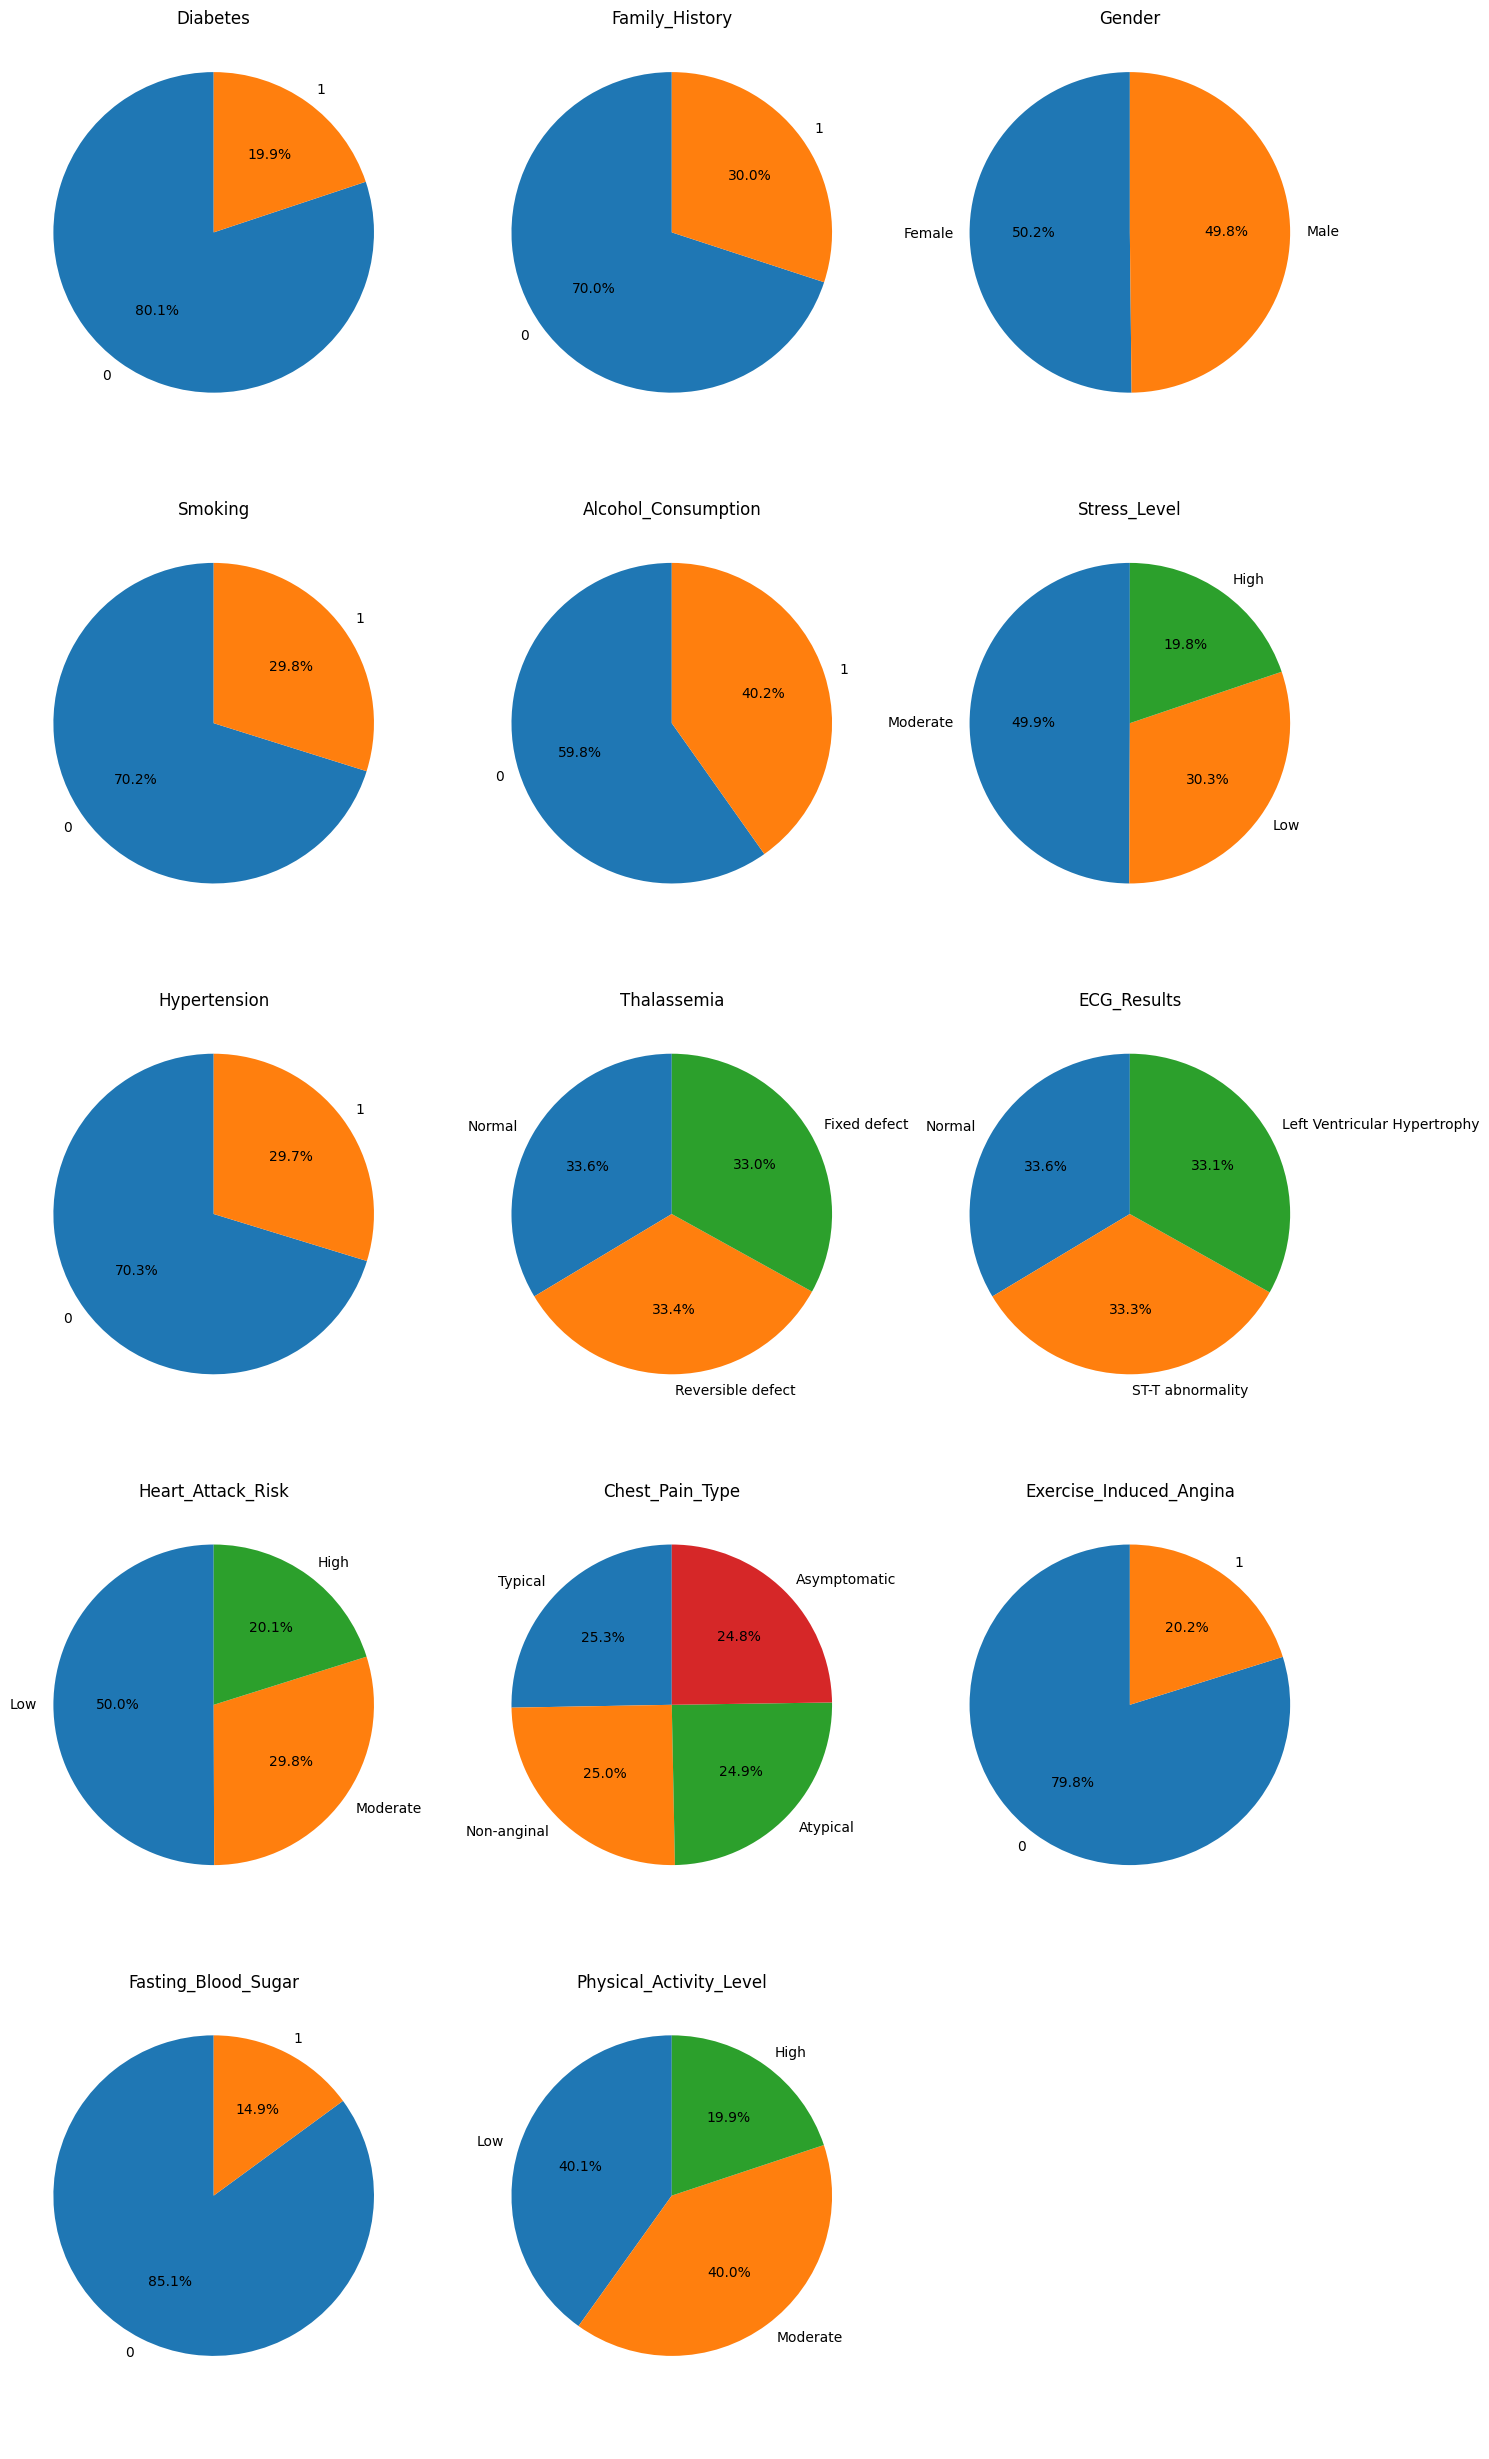

In [56]:
# visuele voorstellen van de unbalance van de categorische variabelen
# Creëer een figuur en een set van subplots
num_columns = 3
num_plots = len(df_cat.columns)
num_rows = (num_plots + num_columns - 1) // num_columns
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, num_rows * 5))

# Flatten het axes object voor eenvoudiger iteratie
axes = axes.flatten()

# Loop over alle kolommen en creëer een pie chart voor elke kolom
for i, column in enumerate(df_cat.columns):
    # Haal de waarde tellingen op voor de huidige kolom
    counts = df_cat[column].value_counts()
    
    # Maak een pie chart op de i-th positie in axes
    axes[i].pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90)
    axes[i].set_title(column)
    axes[i].set_ylabel('')  # Verwijder de y-label voor netheid

# Verberg eventuele extra subplots als het aantal kolommen minder is dan het aantal subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Toon de plot
plt.tight_layout()
save_fig(f"Categorische features unbalance view")
plt.show()



In [57]:
# SMOTE toepassen
# we gaan dit later mee in de pipelining integreren om te kijken wat het effect van SMOTE kan zijn

from collections import Counter
import pandas as pd

# Voorbeeld dataset genereren
X, y = make_classification(n_classes=2, class_sep=2, weights=[0.1, 0.9], n_informative=3, n_redundant=1, flip_y=0,
                           n_features=20, n_clusters_per_class=1, n_samples=1000, random_state=10)


# Data in een DataFrame plaatsen voor visualisatie
df_smote = pd.DataFrame(X)
df_smote['target'] = y

# Toon de klasse distributie voor SMOTE
print('Originele dataset shape %s' % Counter(y))

# Pas SMOTE toe
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

# Toon de nieuwe klasse distributie
print('Resampled dataset shape %s' % Counter(y_res))


from imblearn.under_sampling import RandomUnderSampler

# Toon de originele klasse distributie
print('Originele dataset shape %s' % Counter(y))

# Configureer de RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
X_res_under, y_res_under = rus.fit_resample(X, y)

# Toon de nieuwe klasse distributie
print('Dataset shape na undersampling %s' % Counter(y_res_under))


Originele dataset shape Counter({np.int64(1): 900, np.int64(0): 100})
Resampled dataset shape Counter({np.int64(0): 900, np.int64(1): 900})
Originele dataset shape Counter({np.int64(1): 900, np.int64(0): 100})
Dataset shape na undersampling Counter({np.int64(0): 100, np.int64(1): 100})


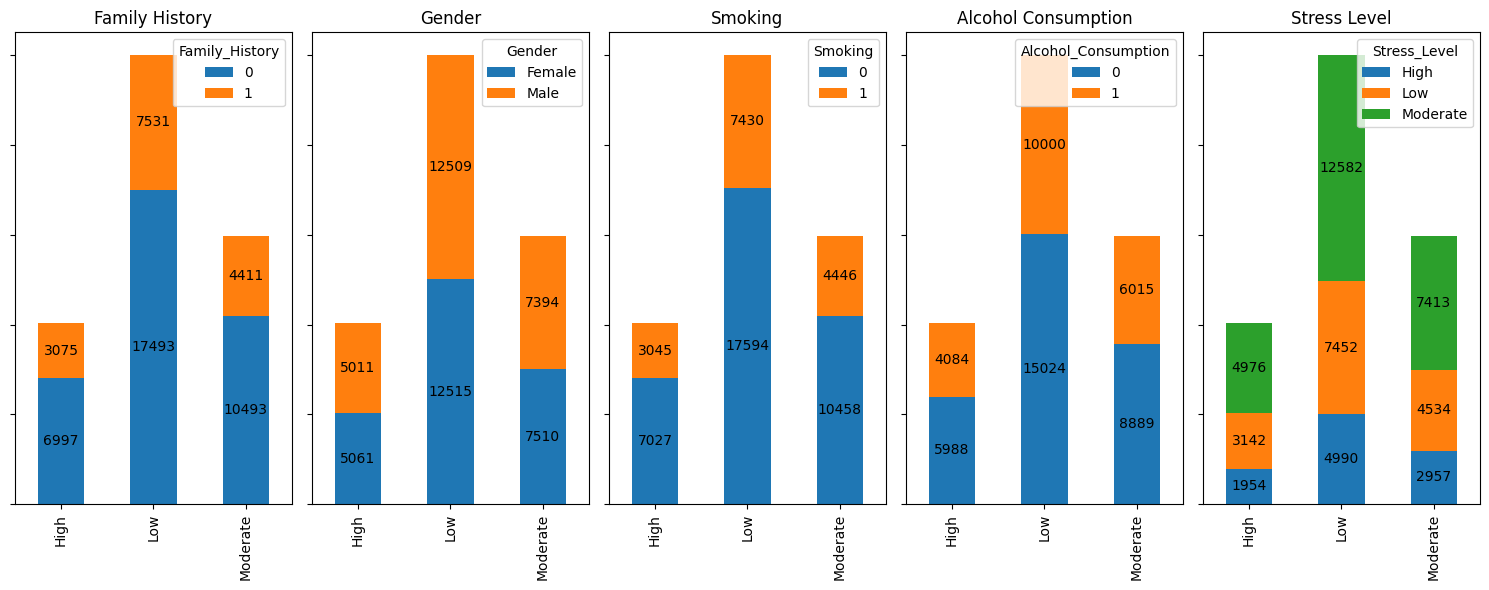

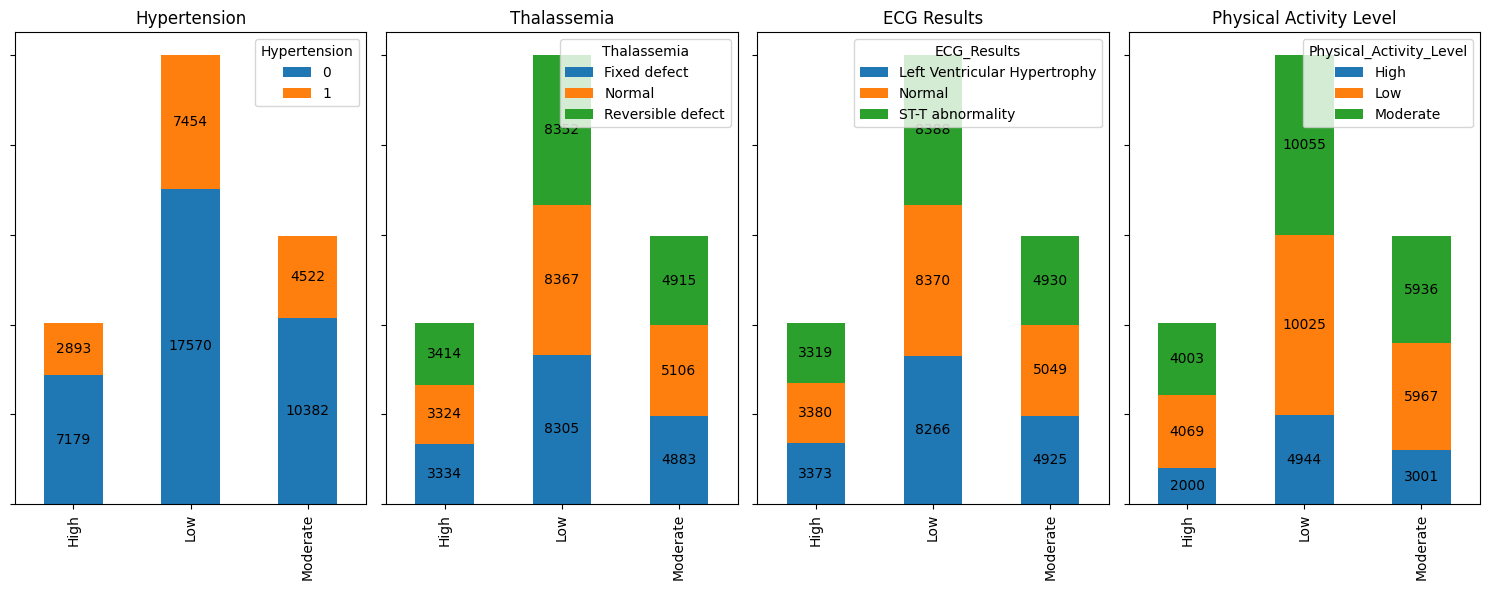

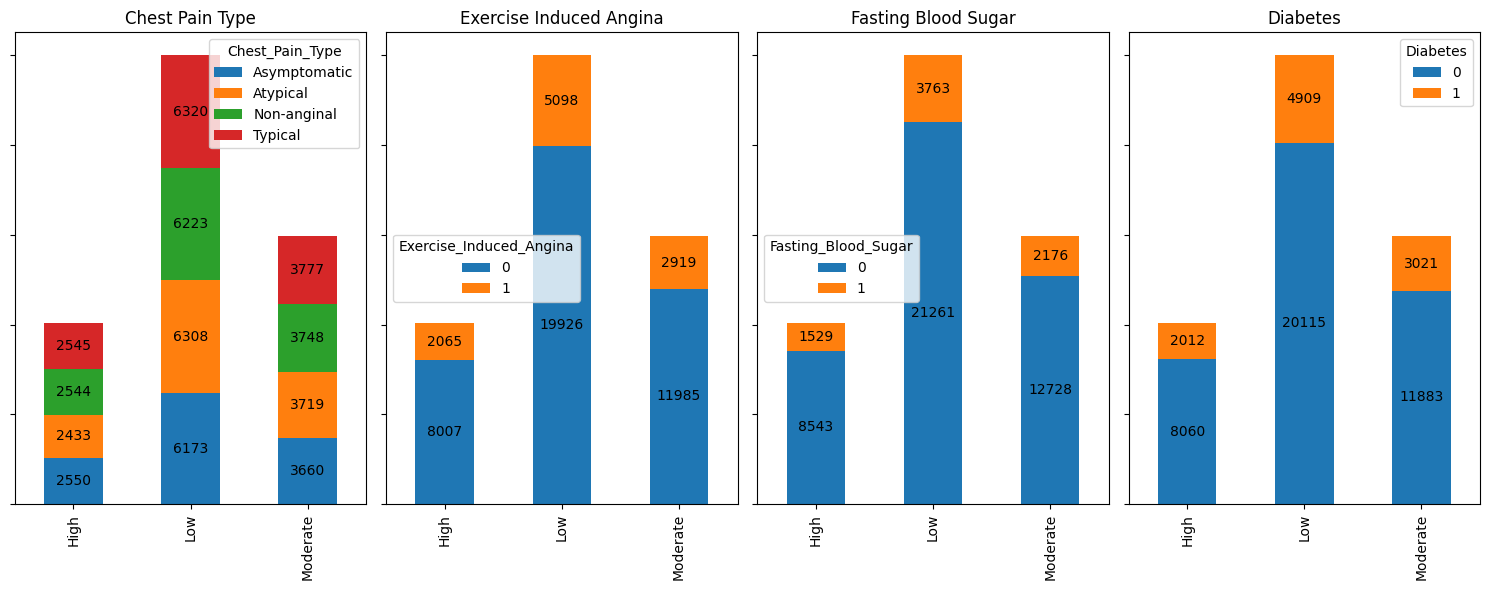

In [58]:
# en nu gaan we op basis van de target value ("Heart risk") groeperen en kijken wat de impact is van de diverse
# categorische variabelen

index = 0

grouped = df.groupby(df_label_col)

df_group_cols = list(set(df_cat_col) - set(df_label_col))
# plot 13 grafieken, 
if plot_graphs:
    for j in [5, 4, 4]:
        fig, axes = plt.subplots(ncols=j, figsize=(15, 6))
        for i in range(j):
            grouped[df_group_cols[index]].value_counts().unstack().plot(kind="bar", stacked=True, ax=axes[i])
            bar_labels(axes[i], 0, "center")
            axes[i].set_title(df_group_cols[index].replace('_', ' '))
            index+=1
        plt.tight_layout()
        save_fig(f"Categorische features per value van de target value deel {r}")
        plt.show()

In [ ]:
# eenvoudige uitwerking van logistic classification
# baseline berekening

df = df_raw.copy() 

label_mapping = {}
encoder = LabelEncoder()

df_cat_all = list(set(df.columns) - set(df_num_col))

for col in df_cat_all:
    df[col] = encoder.fit_transform(df[col])
    label_mapping[col] = dict(zip(encoder.classes_,encoder.transform(encoder.classes_)))

print("\nLabel Mapping:")
for col, mapping in label_mapping.items():
    print("*"*50)
    print(f"{col} : {mapping}")


x = df.drop('Heart_Attack_Risk', axis=1)
y = df['Heart_Attack_Risk']

# Split the data into train and testing 
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2, random_state=42)

print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)

LR_model = LogisticRegression()
LR_model.fit(x_train, y_train)
y_pred = LR_model.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
classification = classification_report(y_test, y_pred)

print(f"Accuracy Score: {accuracy:.4f}")
print(f"Confusion Matrix: \n{confusion}")
print(f"Classification Report: \n{classification}")





Label Mapping:
**************************************************
Diabetes : {np.int64(0): np.int64(0), np.int64(1): np.int64(1)}
**************************************************
Family_History : {np.int64(0): np.int64(0), np.int64(1): np.int64(1)}
**************************************************
Gender : {'Female': np.int64(0), 'Male': np.int64(1)}
**************************************************
Smoking : {np.int64(0): np.int64(0), np.int64(1): np.int64(1)}
**************************************************
Alcohol_Consumption : {np.int64(0): np.int64(0), np.int64(1): np.int64(1)}
**************************************************
Stress_Level : {'High': np.int64(0), 'Low': np.int64(1), 'Moderate': np.int64(2)}
**************************************************
Hypertension : {np.int64(0): np.int64(0), np.int64(1): np.int64(1)}
**************************************************
Thalassemia : {'Fixed defect': np.int64(0), 'Normal': np.int64(1), 'Reversible defect': np.int64(2)}

c:\Users\geert\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\geert\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\geert\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.p

In [63]:
# feature preparation

df = df_raw.copy()

# Separate features (X) and target variable (y)
X = df.drop(columns=['Heart_Attack_Risk'])
y = df['Heart_Attack_Risk']

# Splitting the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define categorical and numerical column names

df_col = X.columns  # zonder de target value!!
df_num_col = ['Age', 'BMI', 'Cholesterol_Level', 'Resting_BP', 'Heart_Rate', 'Max_Heart_Rate_Achieved']
df_cat_col = list(set(df_col) - set(df_num_col))

num_pipeline = Pipeline([   
    ("standardize_numerical", StandardScaler())
])

cat_pipeline = Pipeline(steps=[   
    ('encode_categorical', OneHotEncoder(drop='first'))
])


preprocessor = ColumnTransformer([
    ("numerical", num_pipeline, df_num_col),
    ("categorical", cat_pipeline, df_cat_col)],
     remainder='passthrough')


# Create the pipeline with preprocessing and linear regression
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LogisticRegression())
])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Making predictions on the test set
y_pred = pipeline.predict(X_test)

y_pred_counter = Counter(y_pred)
y_test_counter = Counter(y_test)
log_info(f"Voorkomens in y_pred: {y_pred_counter}")
log_info(f"Voorkomens in y_test: {y_test_counter}")


mape = mean_absolute_percentage_error(y_test, y_pred)


acc_score = accuracy_score(y_pred, y_test)*100
class_report = classification_report(y_pred, y_test)
conf_matrix = confusion_matrix(y_pred, y_test)

log_info(f"\naccuracy_score: {acc_score}")
log_info(f"classification_report: {class_report}")
log_info(f"Confusion matrix: {confusion_matrix}")


# numerische waarden met standardscaler
#


12/02/2025 10:36:02 : Info : Voorkomens in y_pred: Counter({'Low': 10000})
12/02/2025 10:36:11 : Info : Voorkomens in y_test: Counter({'Low': 5083, 'Moderate': 2930, 'High': 1987})


KeyboardInterrupt: 

In [ ]:
# we gaan de nominale categorische variabelen omzetten naar een cijfer.
# Via de OneHotEncoding. 
# Voor de feature "Heart risk" doen we een aparte encoding

# print(df_cat.value_counts().sort_values(ascending=False).head(40))


from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

onehot_encoder = OneHotEncoder(sparse_output=False)
ordinal_encoder = OrdinalEncoder()

# hier zouden we kunnen splitsen tussen de nominale categorische waarden en de ordinall
# bv smoking heeft reeds een waarde van 0 en 1, Diabetes
# maar we gaan alle nominale categorische waarden toch via oneHotEncoding transformeren


df_cat_to_encode = df_cat.drop(columns=df_label_col)
cat_encoded = onehot_encoder.fit_transform(df_cat_to_encode)
# dit geeft een numpy arrry terug
cat_encoded


labels = onehot_encoder.get_feature_names_out()
labels.shape
cat_encoded.shape

# print(onehot_encoder.get_feature_names_out())
# print()

# en we moeten daar terug een dataframe van maken
df_cat_encoded = pd.DataFrame(onehot_encoder.transform(df_cat_to_encode),
                        columns=onehot_encoder.get_feature_names_out(),
                        index=df_cat_to_encode.index)

print(df_cat_encoded.head())
print(df_cat_encoded.shape)



In [ ]:
# feature scaling

from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
num_min_max_scaled = min_max_scaler.fit_transform(df_num)

df_num_min_max_scaled = pd.DataFrame(num_min_max_scaled,
                        columns=df_num_col,
                        index=df_num.index)


if plot_graphs:
    num_columns = 3
    num_plots = len(df_num_min_max_scaled.columns)
    num_rows = (num_plots + num_columns - 1) // num_columns
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, num_rows * 5))
    axes = axes.flatten()
    for i, column in enumerate(df_num_min_max_scaled.columns):
        df_num_min_max_scaled[column].hist(bins=50, ax=axes[i])
        axes[i].set_title(column)
    # Hide any unused subplots
    for i in range(num_plots, len(axes)):
        fig.delaxes(axes[i])
    plt.tight_layout()
    save_fig("Numercal features na min-max_scaling")
    plt.show()

    plot_histogram(df_num_min_max_scaled,"Age")


In [ ]:
# Laatste stap van de feature preparatie, alles terug samen voegen# 
# de scaled numerische waarde : df_num_min_max_scaled
# de onehot encode categorische waarden : df_cat_encoded

print(df_cat_encoded.head())

X = pd.concat([df_num_min_max_scaled, df_cat_encoded], axis=1)
y = df['Heart_Attack_Risk']

print(X.head())
print(y.head())






In [ ]:
# print histogrammen na feature preparation

plot_graphs = True
if plot_graphs:
    num_plots = len(X.columns)
    num_rows = (num_plots + num_columns - 1) // num_columns
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, num_rows * 5))
    axes = axes.flatten()
    for i, column in enumerate(X.columns):
        X[column].hist(bins=50, ax=axes[i])
        axes[i].set_title(column)
    # Hide any unused subplots
    for i in range(num_plots, len(axes)):
        fig.delaxes(axes[i])
    plt.tight_layout()
    save_fig("Feature preparation resultaat")
    plt.show()

In [ ]:
# voorbereiding voor de data voor de modelering 
# splits de data set op training en test sets
# omwille van de unbalance, voeren we eerst een SMOTE uit 


y = y.map({'Low':0,'Moderate':1,'High':2})

#smote = SMOTE(random_state=0)
#X_sampled, y_sampled = smote.fit_resample(X,y)
X_sampled = X.copy()
y_sampled = y.copy()

# y_train = y_train.map({'Low':1,'Moderate':2,'High':3})
# y_test = y_test.map({'Low':1,'Moderate':2,'High':3})

X_train,X_test,y_train,y_test = train_test_split(X_sampled,y_sampled, test_size=0.2, random_state=42)

In [ ]:
y_test.shape
X_test.shape
y_train.shape
X_train.shape

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, MinMaxScaler

from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def bar_labels(axes, rotation=0, location="edge"):
    for container in axes.containers:
        axes.bar_label(container, rotation=rotation, label_type=location)
    axes.set_ylabel("")
    axes.set_xlabel("")
    axes.set_yticklabels(())

rfc = RandomForestClassifier()
abc = AdaBoostClassifier()
gbc = GradientBoostingClassifier()
etc = ExtraTreesClassifier()
svc = SVC()
lgr = LogisticRegression()
xgbc = XGBClassifier()
lgbc = LGBMClassifier(verbose=-100)

models_cl = [rfc, abc, gbc, etc,
         lgr, svc, xgbc, lgbc]

names_cl = ["Random Forest", "Ada Boost", "Gradient Boosting", "Extra Trees",
        "Logistic Regression", "Support Vector Machine", "XGBoost", "LightGBM"]



def training_classification():
    scores, reports, cms = [], dict(), dict()

    for i, j in zip(models_cl, names_cl):
        i.fit(X_train, y_train)
        pred = i.predict(X_test)
        scores += [accuracy_score(pred, y_test)*100]
        reports[j] = classification_report(pred, y_test)
        cms[j] = confusion_matrix(pred, y_test)
    fig, axes = plt.subplots()
    dd = pd.DataFrame({"score": scores}, index=names_cl)
    dd = dd.sort_values("score", ascending=False)
    dd["score"] = round(dd["score"], 2)
    dd["score"].plot(kind="bar", ax=axes)
    bar_labels(axes)
    plt.tight_layout()
    plt.show()

    index = 0

    for _ in range(2):
        fig, axes = plt.subplots(ncols=4, figsize=(15, 6))
        for i in range(4):
            sns.heatmap(cms[dd.index[index]], annot=True, fmt='d', ax=axes[i])
            axes[i].set_title("{}: {}%".format(dd.index[index], dd.iloc[index, 0]))
            index += 1
        plt.tight_layout()
        plt.show()

    for i in dd.index:
        print("*"*30)
        print(i)
        print(reports[i])

        print("\n\n")

df = pd.read_csv("data/heart_attack_risk_dataset.csv")

cats = [i for i in df.columns if df[i].nunique() <= 4]
nums = [i for i in df.columns if i not in cats]

index = 0

for _ in range(2):
    fig, axes = plt.subplots(ncols=7, figsize=(15, 6))
    for i in range(7):
        df[cats[index]].value_counts().plot(kind="bar", ax=axes[i])
        bar_labels(axes[i])
        axes[i].set_title(cats[index].replace('_', ' '))
        index+=1
    plt.tight_layout()
    plt.show()





In [ ]:
training_classification()

In [ ]:


# voor een log regression uit
model_logreg= LogisticRegression()
model_logreg.fit(X_train,y_train)

y_pred = model_logreg.predict(X_test)
report = classification_report(y_test, y_pred)

print("\n\n")
print("**********************************")
print("    Logistic regression output"    )
print("**********************************")
print("Classification Report ")
print(report)
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))


# decision tree model met Optuna 

import optuna

def logistic_regression_optuna(trial): 
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
    
    # Suggest hyperparameters
    C = trial.suggest_loguniform('C', 1e-10, 1e10)
    solver = trial.suggest_categorical('solver', ['lbfgs', 'saga', 'liblinear'])
    
    # Create and fit the model
    model = LogisticRegression(C=C, solver=solver)
    model.fit(x_train, y_train)
    
    # Evaluate the model
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(logistic_regression_optuna, n_trials=100)

print("Best parameters:", study.best_trial.params)
print("Best accuracy:", study.best_trial.value)




# decision tree model
model_decision_tree = DecisionTreeClassifier()
model_decision_tree.fit(X_train,y_train)
y_pred = model_decision_tree.predict(X_test)
report = classification_report(y_test, y_pred)

print("\n\n")
print("**********************************")
print("    Decision Tree Classifier      ")
print("**********************************")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report ")
print(report)
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))




# GridSearch

scoring = { 'accuracy', 'precision', 'recall', 'f1'}

params = {
    'max_depth':[None, 5, 6],
'min_samples_leaf':[1,2, 3],
'min_samples_split':[2,3]
}
gscv_dt = GridSearchCV(model_decision_tree, params, scoring="accuracy", cv=5, refit='f1')
gscv_dt.fit(X_train, y_train)
print("\n\n")
print("**********************************")
print("    Random Forrest Classifier      ")
print("**********************************")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))








In [ ]:
# random forest model
model_random_forest = RandomForestClassifier(
    n_estimators=100,  # Number of trees in the forest
    max_depth=None,    # Maximum depth of the tree (default None for no limit)
    random_state=42,   # Ensures reproducibility
    class_weight='balanced'  # Handles class imbalance
)

model_random_forest.fit(X_train, y_train)
y_pred = model_random_forest.predict(X_test)

# Evaluate the model
print("\n\n")
print("**********************************")
print("    Random Forrest Classifier      ")
print("**********************************")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))


def random_forest_optuna(trial):    
    # Hyperparameters die je wilt optimaliseren
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 5, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    
    # Model creatie
    classifier = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    
    # Cross-validatie gebruiken om modelprestatie te evalueren
    score = cross_val_score(classifier, X, y, n_jobs=-1, cv=3)
    accuracy = np.mean(score)

    return accuracy

# Een studie object creëren die de objective functie maximaliseert
study = optuna.create_study(direction='maximize')
study.optimize(random_forest_optuna, n_trials=100)

print("Beste parameters:", study.best_trial.params)
print("Beste nauwkeurigheid:", study.best_trial.value)



In [ ]:
# Nu met hyper parameter tuning

# GridSearch

# Create and fit the model Logistic Regression

# Specify scoring metrics
model_logistic_regression = LogisticRegression()

# Specify parameter grid to try
params = {
    'max_iter':[100, 200,500],
    'C':[0.1, 1, 10, 100],
    'fit_intercept':[True]
}

# GridSearchCV met 5 fold cross validation. Use f1 as evaluation metric
gscv_lr = GridSearchCV(model_logistic_regression, params, scoring="precision", cv=5, refit='f1')
gscv_lr.fit(X_train, y_train)
y_pred = gscv_lr.best_estimator_.predict(X_test)

print("************************************")
print("    GridSearch Logistic Regression  ")
print("************************************")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))


In [ ]:
model_decision_tree = DecisionTreeClassifier()
scoring = { 'accuracy', 'precision', 'recall', 'f1'}

params = {
    'max_depth':[None, 5, 6],
    'min_samples_leaf':[1,2, 3],
    'min_samples_split':[2,3]
}

gscv_dt = GridSearchCV(model_decision_tree, params, scoring="accuracy", cv=5, refit='f1')
gscv_dt.fit(X_train, y_train)
y_pred = gscv_dt.best_estimator_.predict(X_test)

print("************************************")
print(" GridSearch Decision Tree Regression")
print("************************************")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))


In [ ]:
model_random_forest = RandomForestClassifier()

params = {
    'max_depth':[None, 5],
'min_samples_leaf':[2],
'min_samples_split':[3],
    'n_estimators':[500]
}

gscv_dt = GridSearchCV(model_random_forest, params, scoring="accuracy", cv=5, refit='f1')
gscv_dt.fit(X_train, y_train)
y_pred = gscv_dt.best_estimator_.predict(X_test)

print("***************************************")
print(" GridSearch Random Forest Regression   ")
print("***************************************")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, MinMaxScaler

from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def bar_labels(axes, rotation=0, location="edge"):
    for container in axes.containers:
        axes.bar_label(container, rotation=rotation, label_type=location)
    axes.set_ylabel("")
    axes.set_xlabel("")
    axes.set_yticklabels(())

rfc = RandomForestClassifier()
abc = AdaBoostClassifier()
gbc = GradientBoostingClassifier()
etc = ExtraTreesClassifier()
svc = SVC()
lgr = LogisticRegression()
xgbc = XGBClassifier()
lgbc = LGBMClassifier(verbose=-100)

models_cl = [rfc, abc, gbc, etc,
         lgr, svc, xgbc, lgbc]

names_cl = ["Random Forest", "Ada Boost", "Gradient Boosting", "Extra Trees",
        "Logistic Regression", "Support Vector Machine", "XGBoost", "LightGBM"]



def training_classification():
    scores, reports, cms = [], dict(), dict()

    for i, j in zip(models_cl, names_cl):
        i.fit(X_train, y_train)
        pred = i.predict(X_test)
        scores += [accuracy_score(pred, y_test)*100]
        reports[j] = classification_report(pred, y_test)
        cms[j] = confusion_matrix(pred, y_test)
    fig, axes = plt.subplots()
    dd = pd.DataFrame({"score": scores}, index=names_cl)
    dd = dd.sort_values("score", ascending=False)
    dd["score"] = round(dd["score"], 2)
    dd["score"].plot(kind="bar", ax=axes)
    bar_labels(axes)
    plt.tight_layout()
    plt.show()

    index = 0

    for _ in range(2):
        fig, axes = plt.subplots(ncols=4, figsize=(15, 6))
        for i in range(4):
            sns.heatmap(cms[dd.index[index]], annot=True, fmt='d', ax=axes[i])
            axes[i].set_title("{}: {}%".format(dd.index[index], dd.iloc[index, 0]))
            index += 1
        plt.tight_layout()
        plt.show()

    for i in dd.index:
        print("*"*30)
        print(i)
        print(reports[i])

        print("\n\n")

df = pd.read_csv("data/heart_attack_risk_dataset.csv")

cats = [i for i in df.columns if df[i].nunique() <= 4]
nums = [i for i in df.columns if i not in cats]

index = 0

for _ in range(2):
    fig, axes = plt.subplots(ncols=7, figsize=(15, 6))
    for i in range(7):
        df[cats[index]].value_counts().plot(kind="bar", ax=axes[i])
        bar_labels(axes[i])
        axes[i].set_title(cats[index].replace('_', ' '))
        index+=1
    plt.tight_layout()
    plt.show()

In [ ]:


training_classification()